In [1]:
# Overview of the accuracy of ProtoNN when gamma is calculated heuristically

# import ProtoNN code
import protoNN as protograph
import protoNNTrainer as prototrainer
import utils as utils
# import general libraries
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# need to change the dataset location
X, Y = utils.handleLetter26Dataset('../../../data_set/letter-recognition.data')

dataset = utils.CustomDatasetProtoNN(X, Y, rescaling=True, binary=False)

C:\Users\pietr\anaconda3\envs\edgeml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset input rescaled
Dataset loaded, input space: (20000, 16) , output space: (20000,)
Dataset reshaped, input space: (20000, 16) , output space: (20000, 26)


In [2]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset.data, dataset.labels, test_size=0.2, random_state=0)
train_inputs = torch.from_numpy(X_train.astype(np.float32))
train_targets = torch.from_numpy(Y_train.astype(np.float32))
test_inputs = torch.from_numpy(X_test.astype(np.float32))
test_targets = torch.from_numpy(Y_test.astype(np.float32))
print("Dataset splitted: TRAINING:", train_inputs.shape[0], "TESTING:", test_inputs.shape[0])

Dataset splitted: TRAINING: 16000 TESTING: 4000


In [3]:
# DEFINITION OF HYPERPARAMETER FOR THE PROBLEM
input_dimension = X_train.shape[1]
numOutputLabels = dataset.numClasses
numPrototypes = 5 * numOutputLabels
projection_dimension = 15

# regularizer of W, B and Z: HYPERPARAMETER
# sparsity of W, B and Z: HYPERPARAMETER, CONSTRAINTS OF MEMORY
sparcityW, sparcityB, sparcityZ = 1, 1, 1

np.random.seed(0)

# print structure of ProtoNN
print("input dim:\t", input_dimension,
      "\nnum class:\t", numOutputLabels,
      "\nnum prototypes:\t", numPrototypes,
      "\nporjection dim:\t", projection_dimension)

# initial learning rate of the OPTIMIZER: HYPERPARAMETER
learningRate = 0.1
# lossType: 'l2'
lossType= 'l2'

# TRAINING PHASE
# batchsize: HAS TO BE DEFINED
batchsize = 100
# epochs: HAS TO BE DEFINED
epochs = 100
# printStep: HAS TO BE DEFINED
printStep = 1000
# valStep: HAS TO BE DEFINED
valStep = 100

# print virables of ProtoNN training
print("\nbatch size:\t", batchsize,
      "\nepochs:\t\t", epochs,
      "\nprint step:\t", printStep,
      "\nevaluation step:", valStep)

input dim:	 16 
num class:	 26 
num prototypes:	 130 
porjection dim:	 15

batch size:	 100 
epochs:		 100 
print step:	 1000 
evaluation step: 100


In [4]:
# Initialization of parameter (not covered in protoNN class yet)

# initialize W as random
W = np.random.rand(input_dimension, projection_dimension)
w_tensor = torch.from_numpy(W.astype(np.float32))

# initialize B as k-means on transformed input
transformed_train_input = torch.matmul(train_inputs, w_tensor)
kmeans = KMeans(n_clusters=numPrototypes, random_state=0, n_init=10, max_iter=50).fit(transformed_train_input)
B = kmeans.cluster_centers_.T

# initialize B as samples from the dataset
rng = np.random.default_rng(seed=0)
preB = np.zeros((numPrototypes, projection_dimension))
preZ = np.zeros((numPrototypes, numOutputLabels))
for index_sample in range (0, numPrototypes):
    preB[index_sample] = transformed_train_input[index_sample]
    preZ[index_sample] = Y_train[index_sample]
sampledB = preB.T
sampledZ = preZ.T

# initialize gamma: HYPERPARAMETER, heuristic = gamma = 1/2.5*(median of distance between sample and closest cluster)
transformed_train_input = kmeans.transform(transformed_train_input)
gamma = np.median(transformed_train_input)
gamma = 1 / (2.5 * gamma)

# assaign to each prototype a score
score = torch.zeros([numPrototypes, numOutputLabels], dtype=torch.float32)
score_scaled = torch.zeros([numPrototypes, numOutputLabels], dtype=torch.float32)
assert train_inputs.shape[0] == train_targets.shape[0],"Train input number different from train target number"
for j in range (0, train_targets.shape[0]):
    score[kmeans.labels_[j]] += train_targets[j]
    score_scaled[kmeans.labels_[j]] += train_targets[j]
# Take the most higher value for class of a prototype and zero the others
z = 0
for element in score:
    index = np.argmax(element)
    for value in element:
        z += value
    for x in range (0, numOutputLabels):
        if (x == index):
            element[x] = 1
        else:
            element[x] = 0
for element in score_scaled:
    media = element.mean()
    deviazione = element.std()
    index = np.argmax(element)
    for x in range (0, numOutputLabels):
        element[x] = (element[x] - media) / deviazione
assert z == kmeans.labels_.shape[0], "Sum of score of the prototypes should be equal to the number of sample"
Z = score.T.detach().numpy()
Z_scaled = score_scaled.T.detach().numpy()

In [5]:
# INITIALIZE PROTO NN - k means - argmax
protoNNmodel = protograph.ProtoNN(input_dimension, projection_dimension,
                                  numPrototypes, numOutputLabels,
                                  gamma,
                                  W=W, B=B, Z=Z)
protoNNtrainer = prototrainer.ProtoNNTrainer(protoNNmodel,
                                             sparcityW, sparcityB, sparcityZ,
                                             regW, regB, regZ,
                                             learningRate,
                                             lossType)
print("Model size:", protoNNmodel.getModelSizeAsDense(), "KB")
result_a = protoNNtrainer.train(
                              train_inputs.float(),
                              test_inputs.float(),
                              train_targets.float(),
                              test_targets.float(),
                              batchsize,
                              epochs,
                              printStep,
                              valStep,
                              verbose=False, history=True)


Model size: 22.28 KB


In [6]:
# INITIALIZE PROTO NN - k means - standardized
protoNNmodel = protograph.ProtoNN(input_dimension, projection_dimension,
                                  numPrototypes, numOutputLabels,
                                  gamma,
                                  W=W, B=B, Z=Z_scaled)
protoNNtrainer = prototrainer.ProtoNNTrainer(protoNNmodel,
                                             sparcityW, sparcityB, sparcityZ,
                                             regW, regB, regZ,
                                             learningRate,
                                             lossType)
print("Model size:", protoNNmodel.getModelSizeAsDense(), "KB")
result_b = protoNNtrainer.train(
                              train_inputs.float(),
                              test_inputs.float(),
                              train_targets.float(),
                              test_targets.float(),
                              batchsize,
                              epochs,
                              printStep,
                              valStep,
                              verbose=False, history=True)


Model size: 22.28 KB


In [7]:
# INITIALIZE PROTO NN - B sampled
protoNNmodel = protograph.ProtoNN(input_dimension, projection_dimension,
                                  numPrototypes, numOutputLabels,
                                  gamma,
                                  W=W, B=sampledB, Z=sampledZ)
protoNNtrainer = prototrainer.ProtoNNTrainer(protoNNmodel,
                                             sparcityW, sparcityB, sparcityZ,
                                             regW, regB, regZ,
                                             learningRate,
                                             lossType)
print("Model size:", protoNNmodel.getModelSizeAsDense(), "KB")
result_c = protoNNtrainer.train(
                              train_inputs.float(),
                              test_inputs.float(),
                              train_targets.float(),
                              test_targets.float(),
                              batchsize,
                              epochs,
                              printStep,
                              valStep,
                              verbose=False, history=True)

Model size: 22.28 KB


In [8]:
import matplotlib.pyplot as plt
import winsound

accuarcy_a = np.array(result_a.get('accuracyThroughEpochs'))
accuracy_b = np.array(result_b.get('accuracyThroughEpochs'))
accuarcy_c = np.array(result_c.get('accuracyThroughEpochs'))

<function matplotlib.pyplot.show(close=None, block=None)>

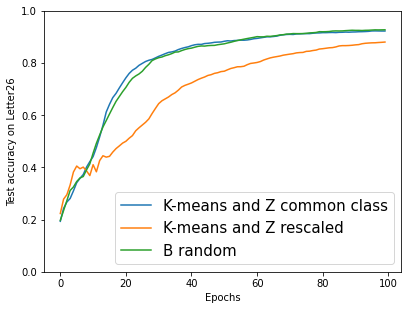

In [9]:
#plt.rcParams["figure.figsize"] = (6.4, 10)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.plot(accuarcy_a)
plt.plot(accuracy_b)
plt.plot(accuarcy_c)
'''
for var in (accuracy_All, accuarcy_Std):
    plt.annotate('%0.2f' % var.max(), xy=(1, var.max()), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
#plt.title('Effect of various parameters',fontweight='bold')
'''
plt.ylabel('Test accuracy on Letter26')
plt.xlabel('Epochs')
plt.ylim([0,1])
plt.legend(['K-means and Z common class', 'K-means and Z rescaled', 'B random'], loc='lower right', prop={'size':15})
plt.show

In [10]:
correct = result_a.get('correctPredictions').item()
total  = result_a.get('totalPredictions')
print("Accuracy K-means and Z argmax:\t", correct / total)
correct = result_b.get('correctPredictions').item()
total  = result_b.get('totalPredictions')
print("Accuracy K-means and Z stdZ:\t", correct / total)
correct = result_c.get('correctPredictions').item()
print("Accuracy B random:\t\t", correct / total)

Accuracy K-means and Z argmax:	 0.92275
Accuracy K-means and Z stdZ:	 0.8805
Accuracy B random:		 0.9275


In [11]:
# to notify that I'm done running
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)
winsound.Beep(500, duration)